# Transfer Learning
*by Marvin Bertin*
<img src="../../images/keras-tensorflow-logo.jpg" width="400">

# Using Transfer Learning to Train an Image Classification Model


Deep learning allows you to learn features automatically from the data. In general this requires a lot of training examples, especially for problems where the input samples are very high-dimensional, like images.

Deep learning models are often trained from scratch, but this can also be an expensive and at time consuming process. Fortunately deep learning models are by nature highly repurposable. Specifically in the case of computer vision, models can be pre-trained on very large-scale datasets (such as ImageNet) and then be reused to solve a different task with high performance. This kind of warm-start training is called Transfer Learning.


There are two main Transfer Learning schemes:
- Pre-trained Convolutional layers as fixed feature extractor
- Fine-tuning on pre-trained Convolutional layers.


# Pre-trained Convolutional layers as fixed feature extractor

<img src="../../images/transfer_learning_1.jpg" width="400">

This scheme treats the Convolutional layers as a fixed feature extractor for the new dataset. Convolutional layers have fixed weights and therefore are not trained. They are used to extract features and construct a rich vector embedding for every image. Once these embeddings have been computed for all images, they become the new inputs and can be used to train a linear classifier or a fully connected network for the new dataset.

In [3]:
import tensorflow as tf
import numpy as np
import glob
from scipy import misc 
import matplotlib.pyplot as plt
%matplotlib inline

tf_keras = tf.contrib.keras





# Feature Extraction

## Load a pre-trained VGG Network on ImageNets

In [2]:
# load pre-trained VGG model
model = tf_keras.applications.VGG19(weights='imagenet',
                                    input_shape = (224, 224, 3))

# Make Predictions on Pre-Trained Model
ImageNet is a famous Computer Vision dataset. It made up of 1.2 million images in the training set, and is composed of 1000 categories that cover a wide variety of objects, animals and scenes.

In [3]:
def make_prediction(img_path):
    
    # Load and resize image
    img = tf_keras.preprocessing.image.load_img(img_path,
                                                target_size=(224, 224))
    
    # transform image into a 4D tensor
    x = tf_keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    # normalize/preprocess image
    x = tf_keras.applications.vgg19.preprocess_input(x)

    # make predcition
    preds = model.predict(x)
    
    # decode the results into a list of tuples
    #(class, description, probability)
    result = tf_keras.applications.vgg19.decode_predictions(
        preds, top=3)[0]

    print("Predictions:\n")
    for idx, (_, name, prob) in enumerate(result):
        print("{}.".format(idx+1))
        print("Name: {}".format(name))
        print("Probability: {}\n".format(prob))

In [2]:
def plot_image(img_path):
    # figure size
    fig = plt.figure(figsize=(8, 8))
    
    # load images
    image = tf_keras.preprocessing.image.load_img(img_path)
    img_array = tf_keras.preprocessing.image.img_to_array(image)
    print("Image size: {}".format(img_array.shape))
    
    # plot image
    plt.imshow(image)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

# Out of Sample Image

Image size: (177, 319, 3)


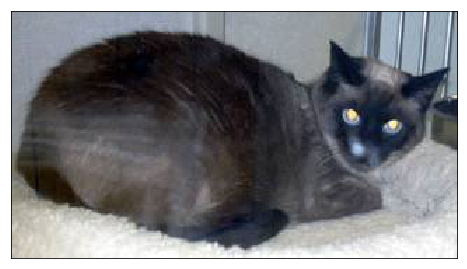

In [22]:
cat_path = "../examples/cat_example.jpg"
plot_image(cat_path)

# Make Predictions

In [43]:
make_prediction(cat_path)

Predictions:

1.
Name: Siamese_cat
Probability: 0.99768102169

2.
Name: lynx
Probability: 0.00079484237358

3.
Name: Egyptian_cat
Probability: 0.000740757328458



Image size: (1794, 1345, 3)


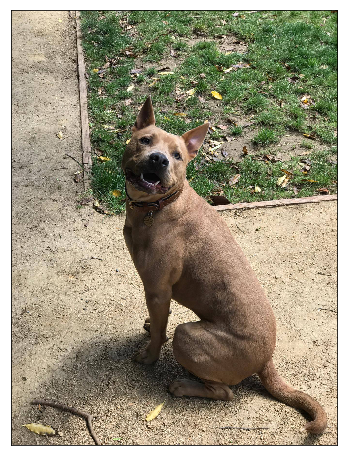

In [40]:
dog_path = "../examples/dog_example.jpg"
plot_image(dog_path)

In [44]:
make_prediction(dog_path)

Predictions:

1.
Name: American_Staffordshire_terrier
Probability: 0.575586855412

2.
Name: bull_mastiff
Probability: 0.242146879435

3.
Name: Staffordshire_bullterrier
Probability: 0.051237296313



# Use pre-trained model for Feature Extraction

In [6]:
train_data_dir = "data/training"
test_data_dir = "data/testing"
# 25000 images
train_size = 20000
test_size = 5000
input_shape = (150, 150, 3)
batch_size = 32

# Load Pre-trained VGG Model (conv layers only)

In [28]:
# load pre-trained VGG model and exclude top dense layers
model = tf_keras.applications.VGG16(include_top=False,
                                    weights='imagenet')

# Load Images to Tensor

In [54]:
def load_data_array(img_files):
    img_size = (150, 150, 3)
    images = []
    for img in img_files:
        try:
            image_ar = misc.imresize(misc.imread(img), img_size)
            if np.asarray(image_ar).shape == img_size:
                images.append(image_ar)
        except:
            print("ERROR: {}".format(img))
            continue

    images = np.asarray(images)
    return images

In [56]:
path_d = glob.glob("data/training/cat/*.jpg")
train_cat = load_data_array(img_files)

In [164]:
path_d = glob.glob("data/training/dog/*.jpg")
train_dog = load_data_array(img_files)

ERROR: data/training/dog/11702.jpg


In [4]:
path_d = glob.glob("data/testing/cat/*.jpg")
test_cat = load_data_array(img_files)

In [5]:
path_d = glob.glob("data/test/dog/*.jpg")
test_dog = load_data_array(img_files)

# Feature Extracting Function

In [6]:
def extract_vgg_features(model, images, data_name):
    
    # Extract image features
    extracted_features = model.predict(images)
    
    # save new features
    file_name = "extracted_features_{}.npy".format(data_name)
    np.save(open(file_name, 'w'), extracted_features)

# Extract and Save Train Set Features
If these functions take to long to run, you can instead load the binary files provided.

In [117]:
# train set (this can take a long time, GPU recommended)
extract_vgg_features(model, train_cat, data_name = 'train_cat')
extract_vgg_features(model, train_dog, data_name = 'train_dog')

# Extract and Save Test Set Features

In [118]:
# test set (this can take a long time, GPU recommended)
extract_vgg_features(model, test_cat, data_name = 'test_cat')
extract_vgg_features(model, test_dog, data_name = 'test_dog')

# Load Generated Features And Reconstruct Label Vectors

In [2]:
# load train set
train_data_cat = np.load(open('extracted_features_train_cat.npy', 'rb'))
train_data_dog = np.load(open('extracted_features_train_dog.npy', 'rb'))
train_data = np.vstack((train_data_cat, train_data_dog))

# generate train labels (the image extracted features were saved in order)
train_labels = np.array([0] * train_data_cat.shape[0]  +
                        [1] * train_data_dog.shape[0])
print("Train size: {}".format(train_data.shape))

Train size: (19970, 4, 4, 512)


In [3]:
# load test set
test_data_cat = np.load(open('extracted_features_test_cat.npy', 'rb'))
test_data_dog = np.load(open('extracted_features_test_dog.npy', 'rb'))
test_data = np.vstack((test_data_cat, test_data_dog))

# generate train labels (the image extracted features were saved in order)
test_labels = np.array([0] * test_data_cat.shape[0]  +
                       [1] * test_data_dog.shape[0])
print("Train size: {}".format(test_data.shape))

Train size: (4996, 4, 4, 512)


# Define a Simple Fully Connected Model

In [4]:
def DNN_Classifier():
    
     # input image tensor
    inputs = tf_keras.layers.Input(shape = (4, 4, 512))
    
    # flatten/reshape layer
    net = tf_keras.layers.Flatten()(inputs)

    # fully connected layer
    net = tf_keras.layers.Dense(256, activation=tf.nn.relu)(net)
    
    # dropout layer
    net = tf_keras.layers.Dropout(0.6)(net)

    # final Dense layer with binary classification
    outputs = tf_keras.layers.Dense(1, activation=tf.nn.sigmoid)(net)

    # model
    model = tf_keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

def compile_model(model):

    # SGD/optimizer
    optimizer = tf_keras.optimizers.RMSprop(lr=0.0001)

    # compile the model with loss, optimizer and evaluation metrics
    model.compile(loss = tf_keras.losses.binary_crossentropy,
                  optimizer = optimizer,
                  metrics = [tf_keras.metrics.binary_accuracy])

    print(model.summary())
    
    return model

In [5]:
model = DNN_Classifier()
model = compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665.0
Trainable params: 2,097,665.0
Non-trainable params: 0.0
_________________________________________________________________
None


# Train Model

In [6]:
history = model.fit(x=train_data, y=train_labels, batch_size=32,
          verbose=2, epochs=20, validation_data=(test_data,test_labels))

Train on 19970 samples, validate on 4996 samples
Epoch 1/20
4s - loss: 1.1374 - binary_accuracy: 0.8995 - val_loss: 0.5400 - val_binary_accuracy: 0.9462
Epoch 2/20
3s - loss: 0.6321 - binary_accuracy: 0.9370 - val_loss: 0.3732 - val_binary_accuracy: 0.9506
Epoch 3/20
3s - loss: 0.3855 - binary_accuracy: 0.9506 - val_loss: 0.2879 - val_binary_accuracy: 0.9544
Epoch 4/20
3s - loss: 0.2534 - binary_accuracy: 0.9611 - val_loss: 0.2875 - val_binary_accuracy: 0.9524
Epoch 5/20
3s - loss: 0.1956 - binary_accuracy: 0.9704 - val_loss: 0.3141 - val_binary_accuracy: 0.9544
Epoch 6/20
3s - loss: 0.1721 - binary_accuracy: 0.9745 - val_loss: 0.3069 - val_binary_accuracy: 0.9542
Epoch 7/20
3s - loss: 0.1285 - binary_accuracy: 0.9786 - val_loss: 0.3042 - val_binary_accuracy: 0.9570
Epoch 8/20
3s - loss: 0.1083 - binary_accuracy: 0.9839 - val_loss: 0.3153 - val_binary_accuracy: 0.9566
Epoch 9/20
3s - loss: 0.0980 - binary_accuracy: 0.9854 - val_loss: 0.3273 - val_binary_accuracy: 0.9560
Epoch 10/20
3s 

# Evaluate Model

In [8]:
model.evaluate(test_data,test_labels, batch_size=32, verbose=1)

4544/4996 [==========================>...] - ETA: 0s

[0.38668078590178934, 0.95736589271417138]

# Plot Accuracy and Loss Over Time

In [11]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('vgg accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('vgg loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

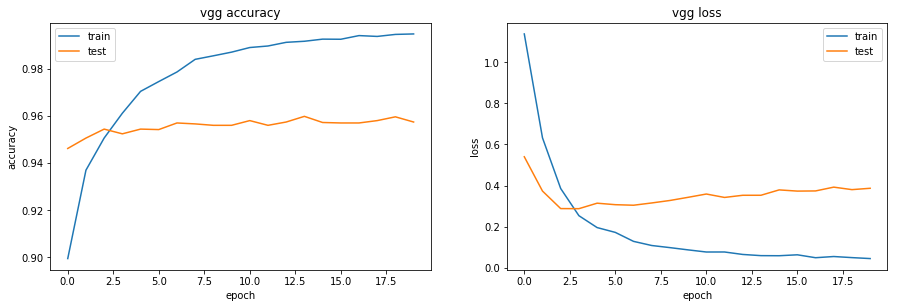

In [15]:
plot_accuracy_and_loss(history)

# Save Model

In [16]:
#save model
model_json = model.to_json()
open('cat_and_dog_model.json', 'w').write(model_json)
model.save_weights('image_classifier_cat_and_dog.h5', overwrite=True)

# Define Fully Connected Network with DNNClassifier Class

TensorFlow provide pre-built estimators, which makes it very easy to construct a multi-layer fully connected network.

In [26]:
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
    train_data)

clf = tf.contrib.learn.DNNClassifier(hidden_units = [256],
                                     feature_columns = feature_columns,
                                     n_classes=2,
                                     optimizer=tf.train.RMSPropOptimizer(
                                         learning_rate=0.0001),
                                     activation_fn=tf.nn.relu,
                                     dropout=0.6)

print("Training the classifier...")
clf.fit(train_data, train_labels,
        steps=5, batch_size=32)

test_pred = clf.predict(test_data, batch_size =32)

print("Evaluating the classifier...")
score = tf.metrics.accuracy(test_labels, test_pred)
print("Accuracy: %f" % score)

# Fine-tuning on pre-trained Convolutional Layers

To further improve the performance of our image classifier, we can "fine-tune" a pre-trained VGG model alongside the top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates.

<img src="../../images/transfer_learning_2.jpeg" width="900">


This consists of the following steps:

- Load pretrained weights from a model trained on another dataset
- Re-initialize the top fully-connected layers with fresh weights
- Train model on new dataset (freeze or not convolutional layers)

This scheme treats the Convolutional layers as part of the model and applies backpropagation through the model. This fine-tunes the weights of the pretrained network to the new task. It is also possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network.

In [2]:
# load pre-trained VGG model and exclude top dense layers
base_model = tf_keras.applications.VGG16(include_top=False,
                                         weights='imagenet',
                                         input_shape=(150, 150, 3))

In [3]:
def fine_tune_VGG(base_model):
    
     # output of convolutional layers
    net = base_model.output    
    
    # flatten/reshape layer
    net = tf_keras.layers.Flatten(
        input_shape=base_model.output_shape[1:])(net)

    # fully connected layer
    net = tf_keras.layers.Dense(256, activation=tf.nn.relu)(net)
    
    # dropout layer
    net = tf_keras.layers.Dropout(0.5)(net)

    # final Dense layer with binary classification
    outputs = tf_keras.layers.Dense(1, activation=tf.nn.sigmoid)(net)

    # define model with base_model's input
    model = tf_keras.models.Model(inputs=base_model.input, outputs=outputs)
    
    # freeze weights of conv blocks 1-4 (15 layers)
    # fine-tune last conv block and dense layers
    for layer in model.layers[:15]:
        layer.trainable = False
    
    return model

def compile_model(model):

    # SGD/optimizer (very slow learning rate)
    optimizer = tf_keras.optimizers.SGD(lr=1e-4, momentum=0.9)

    # compile the model with loss, optimizer and evaluation metrics
    model.compile(loss = tf_keras.losses.binary_crossentropy,
                  optimizer = optimizer,
                  metrics = [tf_keras.metrics.binary_accuracy])

    print(model.summary())
    
    return model

In [4]:
model = fine_tune_VGG(base_model)
model = compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

# Define Train and Test Data Generators

In [7]:
batch_size = 16

# prepare data augmentation configuration
train_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Train and Fine-tune Model

In [22]:
# fine-tune the model
history = model.fit_generator(
        train_generator,
        steps_per_epoch= 5, #train_size // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps= 10) #test_size // batch_size)

Epoch 1/5
5/5 [==============================] - 2s - loss: 0.2555 - binary_accuracy: 0.8625 - val_loss: 0.2381 - val_binary_accuracy: 0.8750
Epoch 2/5
5/5 [==============================] - 2s - loss: 0.1873 - binary_accuracy: 0.9375 - val_loss: 0.1934 - val_binary_accuracy: 0.9250
Epoch 3/5
5/5 [==============================] - 2s - loss: 0.2635 - binary_accuracy: 0.8750 - val_loss: 0.1729 - val_binary_accuracy: 0.9437
Epoch 4/5
5/5 [==============================] - 2s - loss: 0.3842 - binary_accuracy: 0.8250 - val_loss: 0.1771 - val_binary_accuracy: 0.9250
Epoch 5/5
5/5 [==============================] - 2s - loss: 0.2870 - binary_accuracy: 0.8875 - val_loss: 0.2310 - val_binary_accuracy: 0.9000


# Evaluate Trained Model 

In [20]:
# evaluate the model on batches with real-time data augmentation
loss, acc= model.evaluate_generator(validation_generator, steps = 10)
print("loss: {}".format(loss))
print("accuracy: {}".format(acc))

loss: 0.178627771512
accuracy: 0.93125


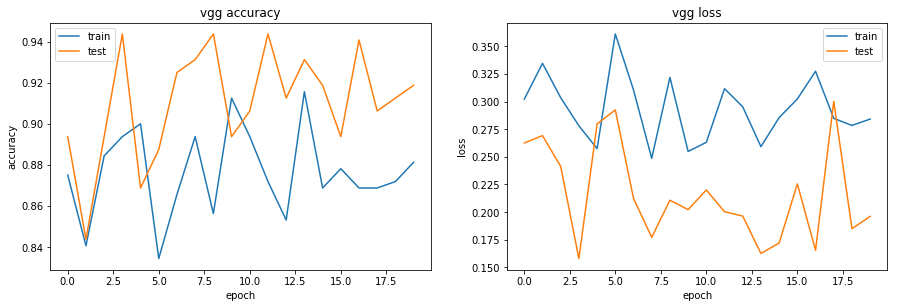

In [21]:
plot_accuracy_and_loss(history)

In [23]:
#save model
model_json = model.to_json()
open('cat_and_dog_fine_tune_model.json', 'w').write(model_json)
model.save_weights('image_classifier_cat_and_dog_fine_tune_.h5',
                   overwrite=True)

## The End

<img src="../../images/divider.png" width="100">